In [ ]:
%load_ext tensorboard
%tensorflow_version 2.x

In [ ]:
from __future__ import print_function

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.datasets import mnist
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras import backend as K
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
import h5py
from skimage.transform import resize
from skimage.color import gray2rgb

batch_size = 256
num_classes = 10
num_epochs = 10
val_size = 5000

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data(path, val_size, num_classes):
    with h5py.File(path+'/train.hdf5', 'r') as f:
        shape = f["X"].shape
        x_train = f["X"][:shape[0]-val_size]
        y_train = f["Y"][:shape[0]-val_size].flatten()
        x_val = f["X"][shape[0]-val_size:]
        y_val = f["Y"][shape[0] - val_size:].flatten()

    with h5py.File(path+'/test.hdf5', 'r') as f:
        x_test = f["X"][:]
        y_test = f["Y"][:].flatten()

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

def reshapeImages(images):
    images_redone = []
    for image in images:
        image = resize(image,(32,32))
        image = gray2rgb(image)
        images_redone.append(image)
    
    images = np.asarray(images_redone)
    images = images.reshape(images.shape[0], 32, 32, 3)
    images = images.astype('float32')
    images /= 255
    print(images.shape[0], 'samples')
    return (images)

def show_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'test_accuracy'], loc='best')
    plt.show()
    
def show_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('#f Iterations')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [ ]:
# the data, split between train and test sets
# The full `train` split and the full `test` split as two distinct datasets.
(x_train_svhn_orig, y_train_svhn_orig), (x_val_svhn, y_val_svhn), (x_test_svhn, y_test_svhn) = load_data('drive/My Drive/Data/svhn', val_size, num_classes)
(x_train_syn_orig, y_train_syn_orig), (x_val_syn, y_val_syn), (x_test_syn, y_test_syn) = load_data('drive/My Drive/Data/synthNumbers', val_size, num_classes)

In [ ]:
y_train_syn_nrs = np.argmax(y_train_syn_orig, axis=-1)
y_train_svhn_nrs = np.argmax(y_train_svhn_orig, axis=-1)

In [ ]:
nr_of_nrs_syn = 2000
x_train_syn = x_train_syn_orig[y_train_syn_nrs == 0][:nr_of_nrs_syn]
y_train_syn = y_train_syn_orig[y_train_syn_nrs == 0][:nr_of_nrs_syn]
for i in range(1, 10):
  x_train_nr = x_train_syn_orig[y_train_syn_nrs == i][:nr_of_nrs_syn]
  y_train_nr = y_train_syn_orig[y_train_syn_nrs == i][:nr_of_nrs_syn]
  x_train_syn = np.vstack((x_train_syn, x_train_nr))
  y_train_syn = np.vstack((y_train_syn, y_train_nr))

from sklearn.utils import shuffle
x_train_syn, y_train_syn = shuffle(x_train_syn, y_train_syn)

In [ ]:
nr_of_nrs_svhn = 1
x_train_svhn = x_train_svhn_orig[y_train_svhn_nrs == 0][:nr_of_nrs_svhn]
y_train_svhn = y_train_svhn_orig[y_train_svhn_nrs == 0][:nr_of_nrs_svhn]
for i in range(1, 10):
  x_train_nr = x_train_svhn_orig[y_train_svhn_nrs == i][:nr_of_nrs_svhn]
  y_train_nr = y_train_svhn_orig[y_train_svhn_nrs == i][:nr_of_nrs_svhn]
  x_train_svhn = np.vstack((x_train_svhn, x_train_nr))
  y_train_svhn = np.vstack((y_train_svhn, y_train_nr))

from sklearn.utils import shuffle
x_train_svhn, y_train_svhn = shuffle(x_train_svhn, y_train_svhn)

In [ ]:
input1 = keras.layers.Input(shape=(32,32,3))
conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu')(input1)
conv2 = keras.layers.Conv2D(32, (3, 3), activation='relu')(conv1)
maxpool1 = keras.layers.MaxPooling2D((2, 2))(conv2)
dropout1 = keras.layers.Dropout(0.1)(maxpool1)
conv3 = keras.layers.Conv2D(64, (3, 3), activation='relu')(dropout1)
conv4 = keras.layers.Conv2D(64, (3, 3), activation='relu')(conv3)
maxpool2 = keras.layers.MaxPooling2D((2, 2))(conv4)
flatten = keras.layers.Flatten()(maxpool2)
dense2 = keras.layers.Dense(512, activation='relu')(flatten)
output = keras.layers.Dense(num_classes, activation='softmax')(dense2)

model = keras.Model(inputs=input1, outputs=[dense2,output])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 64)        3692

In [ ]:
y_train_svhn_zeros = np.zeros((y_train_svhn.shape[0],1))
y_train_svhn_ = np.hstack((y_train_svhn, y_train_svhn_zeros))
y_train_syn_ones = np.ones((y_train_syn.shape[0],1))
y_train_syn_ = np.hstack((y_train_syn, y_train_syn_ones))

In [ ]:
# Instantiate an optimizer to train the model.
optimizer = tf.compat.v1.train.AdamOptimizer()
# Instantiate a loss function.
loss_cc = keras.losses.CategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = keras.metrics.CategoricalAccuracy()
val_acc_metric = keras.metrics.CategoricalAccuracy()

# Prepare the training datasets
train_dataset = tf.data.Dataset.from_tensor_slices((np.concatenate([x_train_svhn, x_train_syn], axis=0), np.concatenate([y_train_svhn_,y_train_syn_],axis=0)))
train_dataset = train_dataset.shuffle(buffer_size=100000).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((np.concatenate([x_val_svhn, x_val_syn], axis=0), np.concatenate([y_val_svhn,y_val_syn],axis=0)))
val_dataset = val_dataset.batch(batch_size)

In [ ]:
def distance_loss(predictions, y, predictions_target, y_target, classes_y):
    def some_function(tensor):
      y_source = tensor[1]
      equal =  tf.math.equal(y_source, y_target)
      equal_all = tf.reduce_all(equal, axis=1)
      contains = tf.boolean_mask(predictions_target, equal_all)
      distance = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(tensor[0], contains)), axis=1))
      # nearest k points
      closest_distance,_ = tf.math.top_k(tf.negative(distance), k=1)
      return tf.abs(closest_distance)
    y_equal_source =  tf.math.equal(classes_y, tf.constant(1, dtype=tf.float32))
    y_equal_all_source = tf.reduce_all(y_equal_source, axis=1)
    predictions_source = tf.boolean_mask(predictions, y_equal_all_source)
    y_source = tf.boolean_mask(y, y_equal_all_source)
    d = tf.map_fn(some_function, (predictions_source,y_source), dtype=tf.float32)
    return tf.math.reduce_sum(d)

In [ ]:
def train_step(model, optimizer, x_batch, y_batch, x_train_target, y_train_target, classes_y):

    with tf.GradientTape() as tape:   
      hidden_logits = model(x_batch, training=True)[0]
      hidden_logits_target = model(x_train_target, training=True)[0]
      loss_dist = distance_loss(hidden_logits, y_batch, hidden_logits_target, y_train_target, classes_y)
      logits = model(x_batch, training=True)[1]
      loss_cross = loss_cc(y_batch, logits)
      loss_value = loss_cross + 0.0005*loss_dist

    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Update training metric.
    train_acc_metric(y_batch, logits)
    return loss_value, loss_dist, loss_cross

In [ ]:
dist_losses = []
train_accuracy = []
cross_entropy_losses = []
val_accuracy = []
num_epochs = 5

for epoch in range(num_epochs):
    print('Start of epoch %d' % (epoch,))
    # Iterate over the batches of the dataset.
    step = 0

    for (x_batch, y_batch) in train_dataset:
      
      classes_y = tf.cast(tf.strided_slice(tf.identity(y_batch), [0,-1], [y_batch.shape[0],y_batch.shape[0]], [1,1]),dtype=tf.float32)
      y_batch_ = tf.cast(tf.strided_slice(tf.identity(y_batch), [0,0], [y_batch.shape[0],-1], [1,1]),dtype=tf.float32)

      loss_value, loss_dist, loss_cross = train_step(model, optimizer, x_batch, y_batch_, tf.constant(x_train_svhn, dtype=tf.float32), tf.constant(y_train_svhn, dtype=tf.float32), classes_y)

      # Log every 250 batches.
      if step % 250 == 0:
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Distance loss and cross entropy loss at step %s: %s  %s' % (step, float(loss_dist),float(loss_cross)))

      step +=1
    
    dist_losses.append(float(loss_dist))
    cross_entropy_losses.append(float(loss_cross))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print('Training acc over epoch: %s' % (float(train_acc),))
    train_accuracy.append(float(train_acc))

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val)[1]
        # Update val metrics
        val_acc_metric(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    print('Validation acc: %s' % (float(val_acc),))
    val_accuracy.append(float(val_acc))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

Start of epoch 0
Training loss (for one batch) at step 0: 1.66447114944458
Distance loss and cross entropy loss at step 0: 372.87750244140625  1.4780323505401611
Training acc over epoch: 0.9895052313804626
Validation acc: 0.8772000074386597
Start of epoch 1
Training loss (for one batch) at step 0: 1.5900659561157227
Distance loss and cross entropy loss at step 0: 199.41006469726562  1.490360975265503
Training acc over epoch: 0.9895052313804626
Validation acc: 0.8792999982833862
Start of epoch 2
Training loss (for one batch) at step 0: 1.5925618410110474
Distance loss and cross entropy loss at step 0: 192.7000732421875  1.4962117671966553
Training acc over epoch: 0.989905059337616
Validation acc: 0.8733000159263611
Start of epoch 3
Training loss (for one batch) at step 0: 1.5835882425308228
Distance loss and cross entropy loss at step 0: 175.74099731445312  1.4957177639007568
Training acc over epoch: 0.991604208946228
Validation acc: 0.8841000199317932
Start of epoch 4
Training loss (fo

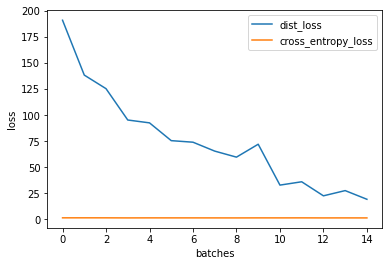

In [ ]:
plt.plot(dist_losses)
plt.plot(cross_entropy_losses)
plt.ylabel('loss')
plt.xlabel('batches')
plt.legend(['dist_loss', 'cross_entropy_loss'], loc='best')
plt.show()

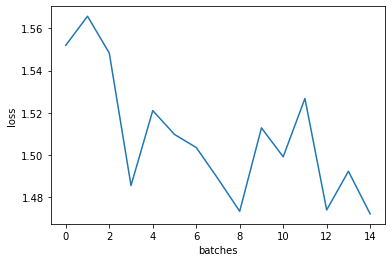

In [ ]:
plt.plot(cross_entropy_losses)
plt.ylabel('loss')
plt.xlabel('batches')
plt.show()

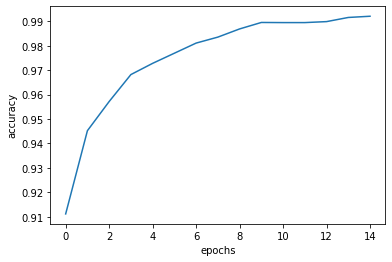

In [ ]:
plt.plot(train_accuracy)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

In [ ]:
# retrain last layer of model on SYN digits and test on SVHN
model_new = keras.models.clone_model(model)
model_new.set_weights(model.get_weights()) 

model_new._layers.pop()
for layer in model_new.layers: layer.trainable = False  

# recover the output from the last layer in the model and use as input to new Dense layer
last = model_new.layers[-1].output
output = keras.layers.Dense(num_classes, activation="softmax", name="output")(last)
model_new = keras.models.Model(model_new.input, output)

for layer in model_new.layers:
    print(layer, layer.trainable)

model_new.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

model_new.summary()

history = model_new.fit(x_train_syn, y_train_syn , val_data = (x_val_syn, y_val_syn), epochs=15,
    shuffle=True,
    verbose=1)

score = model_new.evaluate(x_test_svhn, y_test_svhn, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fe45fa0a550> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe45fa0ab00> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe45fa83d68> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fe45fa22eb8> False
<tensorflow.python.keras.layers.core.Dropout object at 0x7fe45fa22c18> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe45faaed30> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe45fa365c0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fe45fa366a0> False
<tensorflow.python.keras.layers.core.Flatten object at 0x7fe45fa36a20> False
<tensorflow.python.keras.layers.core.Dense object at 0x7fe45fa362b0> False
<tensorflow.python.keras.layers.core.Dense object at 0x7fe45fa26630> True
Model: "model_2"
_________________________________________________________________
Layer (type)     

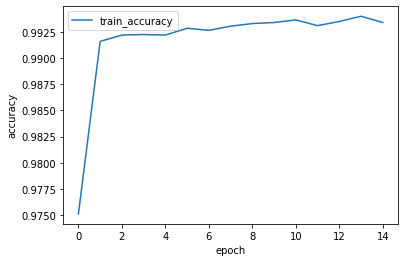

In [ ]:
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy'], loc='best')
plt.show()